<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Copy_of_BenjGaskU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)

**Task**:

Two parts:

1. Propose a data set that's compatible with a generilized linear model structure built with pymc and/or bambi. Your data must have more than three potential predictor variables. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a generalized linear model using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is).
  - You must document and explain your model selection method. This means you must show that your likelihood/link function combo is better than at least one other choice of likelihood/link function.
  - You must document and explain your variable selection method. This means you must show that your final model is better than at least one other version of the model with a different selection of variables.



My intent with this project is to determine the best way to determine an MLB players batting average, using different predictors such as their on base percentage, their amount of home runs, their WAR, and their slugging. If you don't know what those stats are, just check below.

Quick definition of all those listed stats

**Batting Average (BA):** The percentage of time a batter gets a hit, calculated by dividing the amount of hits by at-bats

**On Base Percentage (OBP):** The percentage of time a batter gets on base, calculated by dividing times a person gets on base, through hits, walks, or hit by pitches, by plate appearances

**Wins above replacement (WAR):** This is a complicated stat. The average "replaceable" MLB player has a WAR of 0.0. So if you have a WAR of 2.0, you are 2 wins better than a replacement player, and you provide your team with two wins. It's used to quanitfy a players value to a team to one number, ammount of wins provided.

**Slugging (SLG):** The total number of bases a player records per at-bat. This values different types of hits, as home runs and singles are very different.

Why pick these stats?

All of these different stats are almost more complicated versions of the simple batting average. These stats matter to predicting a batting average, as someone with a high BA likely has high WAR, OBP, SLG, and HR(Home runs).

In [ ]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-fdzee8xw
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-fdzee8xw
  Resolved https://github.com/pydata/xarray.git to commit 609412d8544217247ddf2f72f988da1b38ef01bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import xarray as xr

In [ ]:
!pip install bambi

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import bambi as bmb

In [ ]:
baseball = pd.read_csv('https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv', header=0)
baseball

,k,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos
0,1.0,Jarren Duran*,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,...,129.0,0.373,134.0,330.0,6.0,6.0,1.0,3.0,1.0,OF
1,2.0,Shohei Ohtani*,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,...,190.0,0.449,190.0,411.0,7.0,6.0,0.0,5.0,10.0,DH
2,3.0,Gunnar Henderson*,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,...,159.0,0.385,157.0,333.0,2.0,7.0,0.0,4.0,1.0,SS
3,4.0,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,...,100.0,0.310,100.0,254.0,9.0,3.0,0.0,1.0,2.0,2B
4,5.0,Juan Soto*,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,...,178.0,0.424,179.0,328.0,10.0,4.0,0.0,4.0,2.0,OF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,738.0,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
772,739.0,Kirby Yates*,37.0,TEX,AL,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
773,740.0,Alex Young*,30.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
774,741.0,Guillo Zuñiga,25.0,LAA,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
baseball = baseball.query('PA>200')
baseball = baseball[['Player', 'WAR', 'BA', 'SLG', 'OBP', 'HR', 'Pos']]
baseball

,Player,WAR,BA,SLG,OBP,HR,Pos
0,Jarren Duran*,8.7,0.285,0.492,0.342,21.0,OF
1,Shohei Ohtani*,9.2,0.310,0.646,0.390,54.0,DH
2,Gunnar Henderson*,9.1,0.281,0.529,0.364,37.0,SS
3,Marcus Semien,4.1,0.237,0.391,0.308,23.0,2B
4,Juan Soto*,7.9,0.288,0.569,0.419,41.0,OF
...,...,...,...,...,...,...,...
360,Trent Grisham*,0.4,0.190,0.385,0.290,9.0,OF
361,Kyle Stowers*,-0.5,0.208,0.333,0.268,3.0,UTIL
362,Jackson Holliday*,0.1,0.189,0.311,0.255,5.0,2B
363,Jorge Mateo,0.9,0.229,0.401,0.267,5.0,2B


Little note about the positions. THIS WAS THE MOST TEDIOUS THING EVER. On baseball reference, where I got this data from, every single position was just a number or a bunch of numbers because basically every single player in baseball plays multiple positions. My method was I just simplified it to your most played position, simplifying outfielders to just all three spots and also if someone plays a bunch of positions a lot and has no clear base spot, I labeled them as UTIL, or utility. This was the worst.

In [ ]:
model_WAR_Pos = bmb.Model("`BA` ~ `WAR` + Pos", data=baseball)
idata_WAR_Pos = model_WAR_Pos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='WAR', ylabel='BA'>], dtype=object))

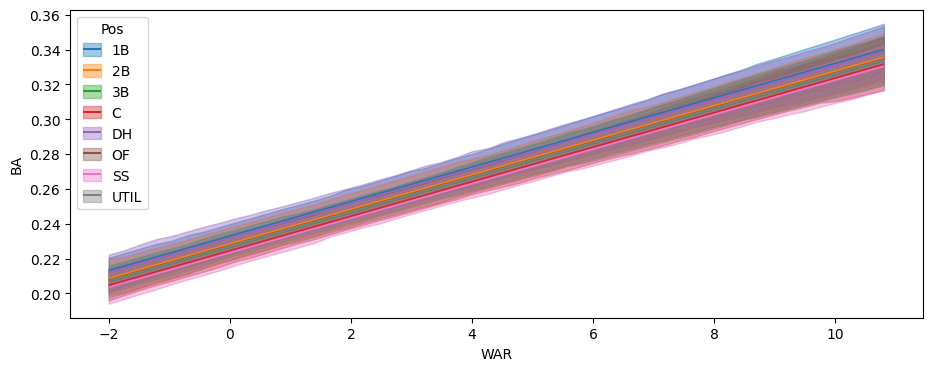

In [ ]:
bmb.interpret.plot_predictions(model_WAR_Pos,
                               idata_WAR_Pos,
                                ["WAR",  "Pos"], fig_kwargs={"figsize":(11, 4)})

That was just me like trying something out to make sure I know how to do it. Clearly that's not what I'm gonna use, but it does confirm that players with higher WAR do indeed have a higher BA

In [ ]:
model_baseball_HR = bmb.Model("`BA` ~ `HR` + Pos + `HR`:Pos", data=baseball)
idata_baseball_HR = model_baseball_HR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='HR', ylabel='BA'>], dtype=object))

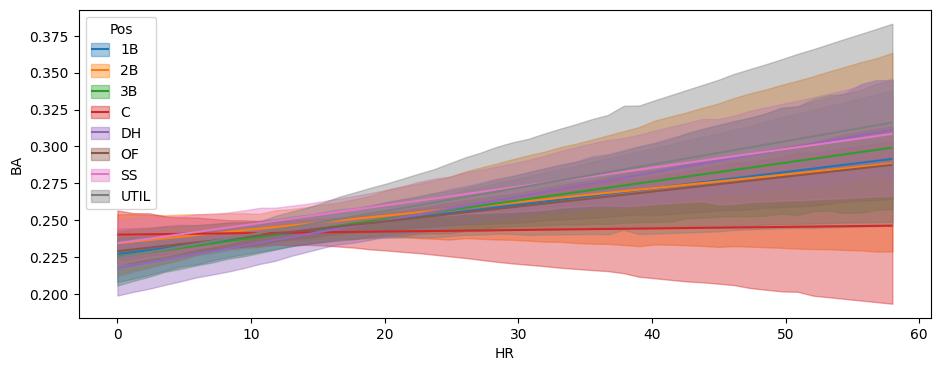

In [ ]:
bmb.interpret.plot_predictions(model_baseball_HR,
                               idata_baseball_HR,
                               ["HR","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

This showing of an interaction between position and home runs shows me a slightly different model, with one clear difference. The catchers. Catching is a very defensive position, so a catcher that hits a high batting average + lots of home runs is almost unheard of, resulting in that being the only position without an increasing slope.



In [ ]:
model_pos_hr_inter = bmb.Model("`BA` ~ `WAR` + Pos + `HR` + Pos:`HR`", data=baseball)
idata_baseball_pos_HR = model_pos_hr_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1400 with 8 Axes>,
 array([[<Axes: title={'center': 'Pos = 1B'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = 2B'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = 3B'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = C'}, xlabel='WAR', ylabel='BA'>],
        [<Axes: title={'center': 'Pos = DH'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = OF'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = SS'}, xlabel='WAR', ylabel='BA'>,
         <Axes: title={'center': 'Pos = UTIL'}, xlabel='WAR', ylabel='BA'>]],
       dtype=object))

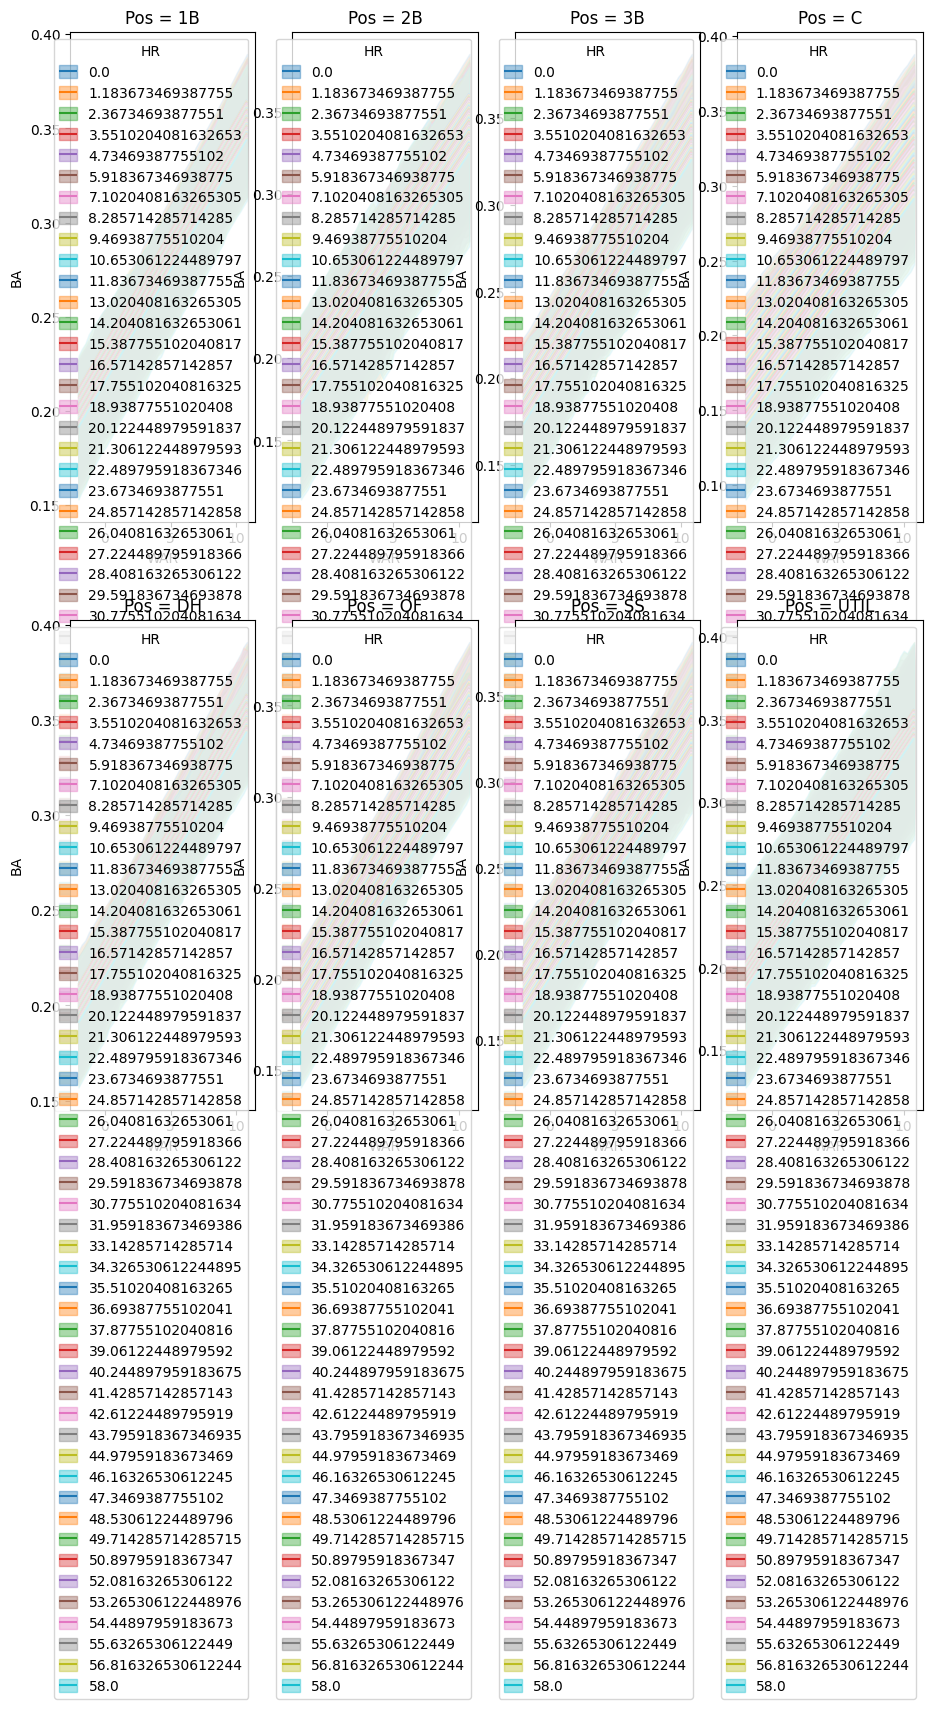

In [ ]:
bmb.interpret.plot_predictions(model_pos_hr_inter,
                               idata_baseball_pos_HR,
                               ["WAR", "HR", "Pos"],
                               fig_kwargs={"figsize":(11, 14)})

That was weird, the over abunfance of data for each possible home run number for every position makes it hard to read, but looking past all those numbers you can see an increasing slope for every single position relative to WAR and BA, with Catchers, because a majority of their WAR comes from defense, being the lowest slope. Next, I want to try a model that takes postion out of the equation, just relying on WAR and HR to determine BA.

In [ ]:
model_HR_WAR = bmb.Model("`BA` ~ `WAR` + `HR` + `WAR`:`HR`", data=baseball)
idata_HR_WAR = model_HR_WAR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='WAR', ylabel='BA'>], dtype=object))

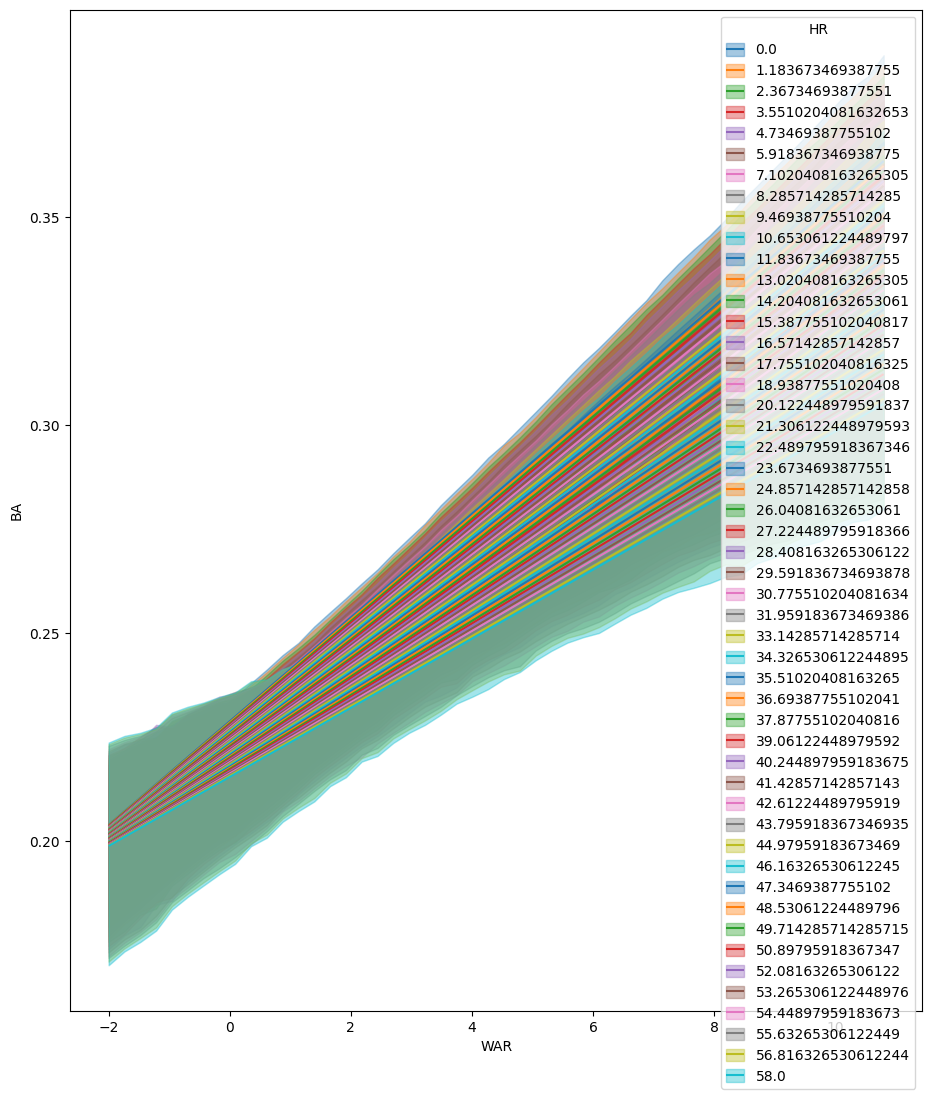

In [ ]:
bmb.interpret.plot_predictions(model_HR_WAR,
                               idata_HR_WAR,
                               ["WAR","HR"],
                               fig_kwargs={"figsize":(11, 13)})

This is a pretty ugly graph but it does get the message across. As WAR increases, Batting Average increases.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

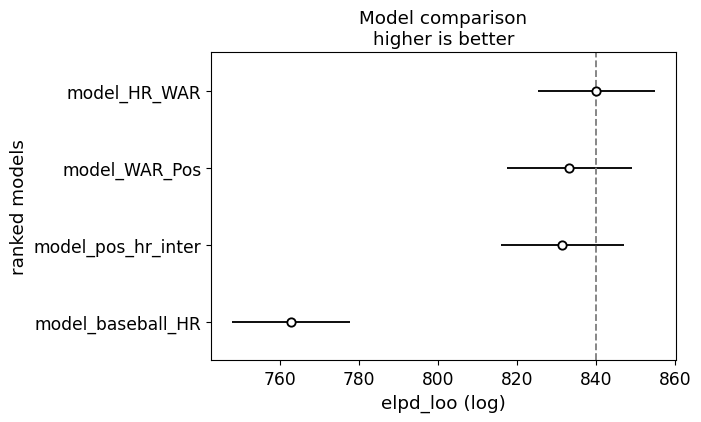

In [ ]:
compare = az.compare({"model_HR_WAR":idata_HR_WAR, "model_pos_hr_inter":idata_baseball_pos_HR, "model_baseball_HR":idata_baseball_HR, "model_WAR_Pos":idata_WAR_Pos})
az.plot_compare(compare)

model_HR_WAR is certainly the strongest model. Not relying on on position makes sense why this would be the strongest model. It makes sense. I chose the postions of every player, and as I said earlier, positions in baseball vary A LOT. So many people were labeled by me as just a 1B or a OF when in reality they play so many other positions, and the crossover creates a difficult case to have an accurate model. I still want to try one more model though.

In [ ]:
model_5 = bmb.Model("`BA` ~ `WAR` + Pos + `HR` + OBP + Pos:`HR`", data=baseball)
idata_5 = model_5.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

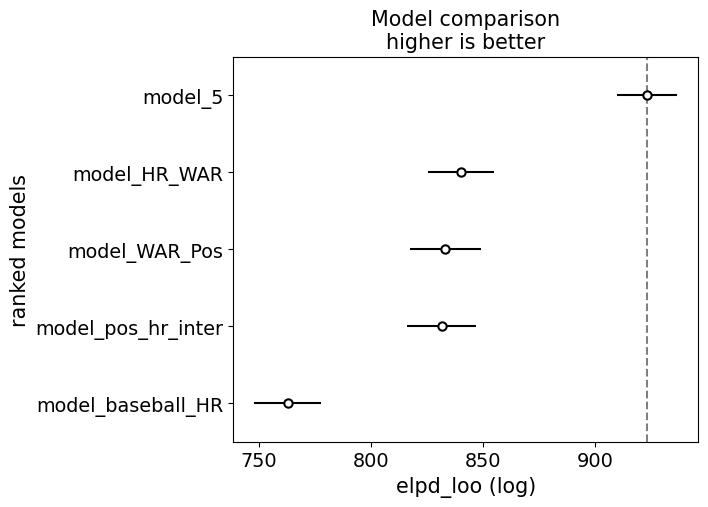

In [ ]:
compare = az.compare({"model_HR_WAR":idata_HR_WAR, "model_pos_hr_inter":idata_baseball_pos_HR, "model_baseball_HR":idata_baseball_HR, "model_WAR_Pos":idata_WAR_Pos, "model_5":idata_5})
az.plot_compare(compare)

This other model is MUCH MORE accurste than all the other previously attempted models.

In [ ]:
bmb.interpret.plot_predictions(model_5,
                               idata_5,
                               ["WAR", "HR-OBP", "Pos"],
                               fig_kwargs={"figsize":(21, 13)})

NameError: name 'bmb' is not defined

This new, more accurate model, is my final model. It confirms what I've been predicting this whole time, with batting average increasing by WAR, with a steady increase by Home runs, althoug that is not as accurate. Once again, relying on position is kind of a weak thought, because of the inaccuracy of positions in the data set and how their isn't truly any difference in position when on offense; everyone hits.